Copyright (C) 2024 Pablo Castells y Alejandro Bellogín

El código que contiene este notebook se ha implementado para la realización de las prácticas de la asignatura "Sistemas de recomendación" del Máster en Ciencia de Datos, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Sistemas de recomendación 2024-25**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Máster en Ciencia de Datos

# Filtrado colaborativo con aprendizaje profundo: EASE, Two-Tower, Transformers

Fechas:

* Comienzo: martes 25 de febrero.
* Entrega: lunes 17 de marzo, 23:59.

## Objetivos

Esta práctica tiene por objetivo comprender el diseño de métodos de filtrado colaborativo mediante deep learning como transición desde un modelo bilineal típico de factorización de matrices hacia modelos neuronales de complejidad arbitraria. En este bloque se desarrollarán:

* Algoritmos de filtrado colaborativo basados en aprendizaje profundo.
* Algoritmos de filtrado colaborativo orientados a datos secuenciales.
* Métricas de evaluación de sistemas de recomendación.

## Material proporcionado

Al igual que en la P1, se proporcionan software y datos para la realización de la práctica:

* Algunas estructuras de datos ya implementadas, para manejar datos de ratings y la salida de los recomendadores.
* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones.
  - Se proporciona una celda de prueba al final de este notebook que deberá funcionar con las implementaciones del estudiante.
  - Junto a la celda de prueba en este mismo notebook, se muestra como referencia un ejemplo de salida generada con una implementación de los profesores.
* Los mismos conjuntos de datos de ratings que se usaban en la P1:
  - Dos conjuntos de juguete para prueba y depuración: <ins>toy1.csv</ins> y <ins>toy2.csv</ins> con ratings ficticios.
  - Un conjunto de datos reales de ratings a películas: *ml-1m.zip* disponible en la Web de [MovieLens](https://grouplens.org/datasets/movielens/1m). De los archivos disponibles, se utilizará sólamente <ins>ratings.dat</ins>, añadiéndole una cabecera `u::i::r::t`.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

En concreto, si para la P1 el estudiante ya hubiera hecho cambios en alguna de estas clases, puede continuar usando dichas modificaciones.

La entrega consistirá en un fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

La celda de prueba deberá ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado).

## Estructuras de datos: ratings y recomendaciones

Se proporcionan:
* Una clase Ratings que permite leer los datos de un fichero de texto, así como un método que genera dos particiones (de forma <b>aleatoria</b> o <b>temporal</b>) de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación.
* Se pueden reutilizar las clases Recommender y Recommendation de la práctica anterior.

In [1]:
import numpy as np
import pandas as pd

class Ratings:
    def __init__(self, file=None, sep=','):
        if file:
            data = pd.read_csv(file, delimiter=sep, engine='python')
            u, i, r, t = data.columns[0:4]
            data.r = 1
            self.m = data.pivot(index=u, columns=i, values=r).fillna(0).to_numpy(dtype=np.float32)
            self.mt = data.pivot(index=u, columns=i, values=t).fillna(-1).to_numpy(dtype=np.float32)
            self.uids = np.sort(data[u].unique())
            self.iids = np.sort(data[i].unique())
            self.uidxs = {u:j for j, u in enumerate(self.uids)}
            self.iidxs = {i:j for j, i in enumerate(self.iids)}
            self._nratings = (self.m > 0).sum()
            self.data = data

    def copy(self, ratings, matrix, temp_matrix):
        self.m = matrix
        self.mt = temp_matrix
        self.uids = ratings.uids
        self.iids = ratings.iids
        self.uidxs = ratings.uidxs
        self.iidxs = ratings.iidxs
        self._nratings = (matrix > 0).sum()
        dfr = pd.DataFrame(columns=self.iids, index=self.uids, data=self.m).unstack().reset_index(name='r')
        dfr.columns = ['i', 'u', 'r']
        dft = pd.DataFrame(columns=self.iids, index=self.uids, data=self.mt).unstack().reset_index(name='t')
        dft.columns = ['i', 'u', 't']
        df_key = ['u','i']
        df = pd.concat([dfr.set_index(df_key).squeeze(), dft.set_index(df_key).squeeze()], keys = ['r','t'],axis=1).fillna(0).reset_index()
        self.data = df[df.r>0][['u', 'i', 'r', 't']].sort_values(by=['u', 'i'])
        return self

    def matrix(self):
        return self.m

    def temporal_matrix(self):
        return self.mt

    def nusers(self):
        return len(self.uids)

    def nitems(self):
        return len(self.iids)

    # uidx can be an int or an array-like of ints.
    def uidx_to_uid(self, uidx):
        return self.uids[uidx]

    # iidx can be an int or an array-like of ints.
    def iidx_to_iid(self, iidx):
        return self.iids[iidx]

    def uid_to_uidx(self, uid):
        return self.uidxs[uid]

    def iid_to_iidx(self, iid):
        return self.iidxs[iid]

    def iidx_rated_by(self, uidx):
        self.m[uidx].nonzero()

    def uidx_who_rated(self, iidx):
        self.m[:, iidx].nonzero()

    def random_split(self, ratio):
        mask = np.random.choice([True, False], size=self.m.shape, p=[ratio, 1-ratio])
        train = self.m * mask
        temp_train = self.mt * mask
        test = self.m * ~mask
        temp_test = self.mt * ~mask
        return Ratings().copy(self, train, temp_train), Ratings().copy(self, test, temp_test)

    def peruser_sequence_split(self, ntestitems=1):
        test_ids_arr = [group.sort_values(by='t', ascending=False)[['u', 'i']].to_numpy()
                    for _, group in self.data.groupby(by='u')]
        test_ids = []
        for user_arr in test_ids_arr:
            for ids in user_arr[:ntestitems]:
                test_ids.append(ids)
        #print(test_ids)
        test_idx = np.array([[self.uid_to_uidx(uid), self.iid_to_iidx(iid)] for uid, iid in test_ids])
        mask = np.ones(self.matrix().shape)
        mask[test_idx[:, 0], test_idx[:, 1]] = 0
        train = self.m * mask
        temp_train = self.mt * mask
        test = self.m * (1-mask)
        temp_test = self.mt * (1-mask)
        return Ratings().copy(self, train, temp_train), Ratings().copy(self, test, temp_test)

    #
    # The remaining functions are just for debugging purposes.
    #

    def rating(self, uid, iid):
        return self.matrix()[self.uid_to_uidx(uid), self.iid_to_iidx(iid)]

    def items_rated_by(self, uid):
        return self.iidx_to_iid(self.iidx_rated_by(self.uid_to_uidx(uid)))

    def users_who_rated(self, iid):
        return self.uidx_to_uid(self.uidx_who_rated(self.iid_to_iidx(iid)))

    def user_ratings(self, uid):
        iidxs = self.matrix()[self.uid_to_uidx(uid)].nonzero()[0]
        return {self.iidx_to_iid(iidx): fround(r) for iidx, r in zip(iidxs, self.matrix()[self.uid_to_uidx(uid), iidxs])}

    def item_ratings(self, iid):
        uidxs = self.matrix()[:, self.iid_to_iidx(iid)].nonzero()[0]
        return {self.uidx_to_uid(uidx): fround(r) for uidx, r in zip(uidxs, self.matrix()[uidxs, self.iid_to_iidx(iid)])}

    def nratings(self):
        return self._nratings

from itertools import islice

# Given a matrix, returns a matrix of positions of top k values per row.
def top_positions_per_row(m, k):
    return np.argpartition(m, -k)[:, -k:]

class Recommendation:
    def __init__(self, scores, n, training):
        scores = scores * (training.matrix() == 0) # Don't recommend rated items.
        # We sort the positions in top_iidx just in order to keep the NumPy tie break by original position
        # (i.e. by ascending object ID) when we use this function later.
        top_iidx = np.sort(top_positions_per_row(scores, min(n, training.nitems())))
        # We sort by -scores because NumPy sorts by ascending and we want descending.
        self.iidx_ranking = np.take_along_axis(top_iidx, np.argsort(-np.take_along_axis(scores, top_iidx, axis=1)), axis=1)
        self.rank_scores = np.take_along_axis(scores, self.iidx_ranking, axis=1)
        ranked_iids = training.iidx_to_iid(self.iidx_ranking)
        self._recommendation = {training.uidx_to_uid(uidx) : [(iid, score) for iid, score in zip(ranked_iids[uidx], self.rank_scores[uidx]) if score > 0]
                                for uidx in range(training.nusers())}

    def ranked_iidx(self):
        return self.iidx_ranking

    def recommendation(self, uid):
        return self._recommendation[uid]

    # This function is for debuggind purposes.
    # Format the recommendation as a string for the first n users. Trim scores to 4 decimal digits.
    def display(self, n):
        r = ''
        for uid in islice(self._recommendation, n):
            r += f'    User {uid} -> <'
            for iid, score in self.recommendation(uid):
                r += f'{iid}:{str(fround(score, 4))} '
            r = (r[:-1] + '>\n') if len(self.recommendation(uid)) > 0 else r + 'empty>\n'
        return r[:-1]

class Recommender():
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    def recommend(self, n):
        return Recommendation(self.scores, n, self.training)

# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

## Ejercicio 1: EASE

Implementar un modelo de filtrado colaborativo lineal basado en autoencoders.

Observación: el parámetro _threshold_ indica a partir de qué valor se binariza la matriz de entrada, es decir, qué valores se consideran como positivos o negativos.

In [2]:
class Ease(Recommender):
    def __init__(self, training, l=20, threshold=3):
        super().__init__(training)
        X = training.matrix()

        # Aplicar el umbral: convierte en 0 las interacciones con valores < threshold
        X = np.where(X >= threshold, X, 0)

        G = X.T @ X  # Matriz de covarianza
        diag_indices = np.diag_indices_from(G)
        G[diag_indices] += l  # Regularización L2

        P = np.linalg.inv(G)  # Inversa de la matriz regularizada
        B = -P / np.diag(P)[:, None]  # Obtención de los pesos del modelo
        B[diag_indices] = 0  # Evitar la auto-referencia en la predicción

        self.scores = X @ B

### Ejercicio 1 &ndash; Explicación/documentación

EASE es un modelo de filtro colaborativo basado en item. Se caracteriza por ser muy sencillo pero eficiente. Los pasos clave que presenta este algoritmo son los siguientes:
* A la matriz de ratings $X$ se le aplica un umbral para filtrar los ratings de mayor puntuación para que el modelo se centre en los items mejor valorados, reduciendo además el ruido de los datos.
* Se calcula la matriz de similitud (covarianza) entre los items que refleja la frecuencia con la que dos items son evaluados conjuntamente por los usuarios.
* Se añade un término de regularización $l$ para evitar problemas de inestabilidad numérica y sobreajuste ya que se penaliza los coeficientes de la matriz de similitud excesivamente grandes.
* Se calcula la matriz de pesos $B$ a partir de la matriz de covarianza regularizada y se elimina la auto-referencia de los items para predecir. Esto garantiza que la predicción para un item no dependa de sí mismo.
* Se calculan las puntuaciones de recomendación a partir de la matriz de pesos y de la matriz de ratings. Estos scores indican la relevancia (o probabilidad) de que un usuario interactúe con un item, basado únicamente en la similitud entre ítems.

## Ejercicio 2: Factorización de matrices: modelo deep learning

Como alternativa a la implementación realizada en la P1 del modelo de factorización de matrices, en esta práctica vas a reformular esa implementación como un caso particular "degenerado" de arquitectura neuronal.

### Implementación en TensorFlow

Completar los huecos marcados con `# Your code here...`.

Observaciones:
* Por la estructura de datos de entrenamiento que maneja TensorFlow, entrenar con toda la matriz de ratings (incluyendo todas las celdas sin dato) es demasiado costoso. Por ello se tomará una muestra pequeña de ejemplos negativos en cada época.
* En el esqueleto que aquí se proporciona, no se genera la traza (curva) de P@10 durante el entrenamiento ya que no encaja fácilmente en el API Keras de TensorFlow.

In [3]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime
import matplotlib.pyplot as plt

class DLMFRecommender(Recommender):
    def __init__(self, training, k=50, lrate=0.01, nepochs=150, neg=4):
        super().__init__(training)
        # Create the model - this will directly trigger training.
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        self.model, self.hist = self.create_model(training, k, lrate, neg, nepochs)
        # Plot the training error and report the final test metric value (P@10).
        # Your code here...
        plt.figure()
        plt.plot(self.hist.history['loss'])
        plt.title('Training Error')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.show()

        uexplode = np.full((training.nitems(), training.nusers()), np.arange(training.nusers())).T.flatten()
        iexplode = np.full((training.nusers(), training.nitems()), np.arange(training.nitems())).flatten()
        self.scores = self.model.predict([uexplode, iexplode], batch_size=training.nusers()*100,
                            verbose=1).reshape(training.nusers(), training.nitems())

    def create_model(self, ratings, k, lrate, neg, nepochs):
        # 'users' is an input layer of type tf.int64.
        users = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="users")
        user_embeddings = tf.keras.layers.Embedding(
                                input_dim=ratings.nusers(),
                                output_dim=k,
                                name="user_embedding"
                            )(users)
        # 'items' is an input layer of type tf.int64.
        items = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="items")
        item_embeddings = tf.keras.layers.Embedding(
                                input_dim=ratings.nitems(),
                                output_dim=k,
                                name="item_embedding"
                            )(items)
        # TensorFlow has a built-in dot-product layer.
        dot = tf.keras.layers.Dot(axes=1, normalize=False)([user_embeddings, item_embeddings])
        # Now we need a generic model that wraps up the "network", specifying the input and output layers.
        model = tf.keras.Model(inputs=[users, items], outputs=dot)

        # Compile the model: Adam optimizer is suggested here over SGD.
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
            loss='mse'
        )

        # Show the model topology
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

        hist = self.train_model(ratings, model, neg, nepochs)
        return model, hist

    def train_model(self, ratings, tf_mf, neg, nepochs):
        # We inject 'neg' negative samples for every available rating in the training data
        nneg = neg * ratings.nratings()
        user_ids = np.concatenate(([ratings.uid_to_uidx(u) for u in ratings.data.u], np.random.choice(list(ratings.uidxs.values()), size=nneg)))
        item_ids = np.concatenate(([ratings.iid_to_iidx(u) for u in ratings.data.i], np.random.choice(list(ratings.iidxs.values()), size=nneg)))
        rs = ratings.matrix()[user_ids, item_ids]
        batch_size = ratings.nratings() + nneg # Single batch with all the data at once.

        # Your code here... to actually do the training
        hist = tf_mf.fit(
            x=[user_ids, item_ids],
            y=rs,
            epochs=nepochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[TqdmCallback(verbose=0)]
        ) # Produces a prettier progress bar.
        return hist

### Ejercicio 2 &ndash; Explicación/documentación

La factorización de matrices para recomendación es un caso concreto de recomendación con redes neuronales. Así, se realiza una extensión del recomendador realizado en la práctica anterior. Los pasos necesarios para realizar este modelo son:
* Creación de dos capas de embeddings, una para usuarios y otra para items. Cada usuario y cada item se representan de esta forma como un vector en un espacio de dimensión $k$, que capturan las características implícitas que explican los ratings (como gustos o preferencias).
* La medida de la similitud es similar a la calculada con una factorización de matrices pura. Se utiliza el producto entre los embeddings de usuarios e items para calcular la predicción (la salida es el rating a predecir). Es equivalente a la factorización matricial.
* Se entrena el modelo con el optimizador Adam y con la función de pérdida MSE.
* Además, se generan ejemplos negativos adicionales (ejemplos que se corresponden con ausencia de ratings).
* Por último, es necesario destacar que se entrena en un único batch que combina las muestras reales y las negativas para simplificar el entrenamiento y procesar toda la información a la vez.

## Ejercicio 3: Implementación modelo Two-Tower

Implementar tu propia versión de un modelo Two-Tower a partir de la arquitectura implementada de MF en el ejercicio anterior.

In [4]:
class TwoTowerRecommender(DLMFRecommender):
    def create_model(self, ratings, k, lrate, neg, nepochs):
        # Torre de usuarios:
        users = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="users")
        user_embedding = tf.keras.layers.Embedding(
            input_dim=ratings.nusers(),
            output_dim=k,
            name="user_embedding"
        )(users)
        # Aplanamos el embedding y agregamos una capa densa para transformar la representación
        user_vector = tf.keras.layers.Flatten()(user_embedding)
        user_dense = tf.keras.layers.Dense(k, activation="relu", name="user_dense")(user_vector)

        # Torre de ítems:
        items = tf.keras.layers.Input(shape=(), dtype=tf.int64, name="items")
        item_embedding = tf.keras.layers.Embedding(
            input_dim=ratings.nitems(),
            output_dim=k,
            name="item_embedding"
        )(items)
        item_vector = tf.keras.layers.Flatten()(item_embedding)
        item_dense = tf.keras.layers.Dense(k, activation="relu", name="item_dense")(item_vector)

        # Combinación de las dos torres mediante producto punto:
        dot = tf.keras.layers.Dot(axes=1, normalize=False, name="dot_product")([user_dense, item_dense])

        # Definición y compilación del modelo:
        model = tf.keras.Model(inputs=[users, items], outputs=dot)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), loss='mse')

        # Mostrar la arquitectura y generar el gráfico del modelo:
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

        # Entrenamiento del modelo (utilizando el método heredado train_model)
        hist = self.train_model(ratings, model, neg, nepochs)
        return model, hist


### Ejercicio 3 &ndash; Explicación/documentación

El modelo de recomendación basado en la arquitectura de dos torres (Two Tower) se emplea para ampliar el modelo anterior. De esta forma, se realizan dos representaciones (o embeddings) diferentes para usuarios y para items, que más tarde se combinan para predecir los ratings. Los pasos de esta arquitectura son:

* Creación de las dos torres. Se crean las torres de usuarios e items por separado. En ambas, se le introduce a la torre un input (los usuarios o los items) que se transforman en un embedding denso que representa las características latentes en un espacio diferente de los usuarios o de los items. Más adelante se aplica un aplanamiento al embedding y se pasa por una capa densa con ReLU lo que permite transofrmar la representación latente a una más refinada.
* Similarmente al caso anterior, se aplica el producto escalar para obtener la predicción del rating.
* Para entrenar este modelo se utiliza el optimizador Adam y la función de pérdida MSE así como la generación de muestras negativas para que el modelo sea capaz de obtener las diferencias entre ratings y la ausencia de ellos.

## Ejercicio 4: Recomendación secuencial

Vas a implementar tu propia versión de un modelo basado en Transformers, en concreto, la del algoritmo SASRec, que incluye un embedding posicional y un modelo causal en la capa de atención.

Para ello, puedes revisar la siguiente implementación de un modelo basado en GRU, aunque tu versión puede hacer un procesamiento por lotes mucho más sencillo (aquí se han hecho los mismos mini-lotes en paralelo que en la propuesta original).

In [5]:
class SessionDataset:
      def __init__(self, df, n):
          self.df = df.sort_values(by = ['s', 't']).reset_index(drop = True)
          self.offsets    = np.concatenate((np.zeros(1, dtype = np.int32), self.df.groupby('s').size().cumsum().values))
          self.n_sessions = len(self.offsets) - 1
          self.item_to_id = {item : i for i, item in enumerate(self.df.i.unique())}
          self.n_items = len(self.item_to_id)
          self.n = n

      def item_to_one_hot(self, item):
          return tf.one_hot(self.item_to_id[item], depth = self.n)

      def extract_session(self, i, one_hot_encoded = True):
          session = self.df[self.offsets[i]:self.offsets[i+1]].copy()
          if one_hot_encoded:
              session.loc[:, 'i'] = session.i.apply(lambda x : self.item_to_one_hot(x))
          return session.i.values.tolist()

def from_ratings_to_sessions(ratings, session_size):
    ratings_sorted = ratings.data.sort_values(by=["u", "t"])
    data_sessions = []
    cur_session = 0
    cur_session_length = 0
    cur_user = None
    def my_fun(row):
        nonlocal data_sessions
        nonlocal cur_session
        nonlocal cur_session_length
        nonlocal cur_user

        if not cur_user:
            cur_user = row.u
        if row.u != cur_user:
            cur_user = row.u
            cur_session += 1
            cur_session_length = 0
        if row.u == cur_user:
            cur_session_length += 1
        data_sessions.append(cur_session)
        if session_size and cur_session_length >= session_size:
            cur_session += 1
            cur_session_length = 0

    ratings_sorted.apply(my_fun, axis=1)
    sessions = pd.DataFrame(
        data={
            "u": ratings_sorted.u,
            "i": ratings_sorted.i,
            "r": ratings_sorted.r,
            "t": ratings_sorted.t,
            "s": data_sessions,
        }
    )
    return sessions

class GRU4RecRecommender(Recommender):
    def __init__(self, training, k=50, nepochs=150, steps_per_epoch=100, ngru_layers=1, batch_size=8, session_length=5, compute_final=False):
        super().__init__(training)
        # Create the model - this will directly trigger training.
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        dataset = SessionDataset(from_ratings_to_sessions(training, session_length), training.nitems())
        self.tf_mf, self.hist = self.create_model(dataset, training.nitems(), k, nepochs, steps_per_epoch, ngru_layers, batch_size)
        # Since the network is stateful, the batch size cannot be modified (at least in Keras), so we must always predict batch_size elements at once.
        n_classes = training.nitems()
        # se deberían calcular los estados ocultos para todas las sesiones, pero tarda mucho
        # idealmente, se podría paralelizar este cálculo
        if compute_final:
            final_states = self._calculate_final_states(dataset, self.tf_mf, ngru_layers, k, batch_size, n_classes)
        self._reset_hidden(self.tf_mf, 0)
        y_pred = np.empty(shape = (dataset.n_sessions, n_classes))
        y_pred[:] = None
        X = np.empty(shape = (batch_size, 1, n_classes))
        next_session_id = 0
        for batch_id in range(dataset.n_sessions // batch_size):
            # X contains the penultimate item in the session (= last item in the training set)
            X[:] = None
            for i in range(batch_size):
                X[i, :] = dataset.extract_session(next_session_id)[-1]
                next_session_id += 1
            nlg = 0
            for nl, layer in enumerate(self.tf_mf.layers):
                if self._is_GRU_layer(layer):
                    self.tf_mf.layers[nl].reset_states()
                    nlg += 1
            # objective: predict last element in the session
            y_pred[batch_id * batch_size : (batch_id + 1) * batch_size, :] = self.tf_mf.predict(X, verbose = 0)[:batch_size]

        y_pred = tf.constant(y_pred[:dataset.n_sessions], dtype = tf.float32)
        # recover predictions as item scores for each user for classical recommendation (this should not be done in general, but perform a sequential evaluation)
        self.scores = y_pred.numpy()

    def create_model(self, dataset, n_classes, k, nepochs, steps_per_epoch, ngru_layers, batch_size):
        model = tf.keras.models.Sequential(name="GRU4Rec")
        for i in range(ngru_layers):
            model.add(tf.keras.layers.GRU(name = 'GRU_{}'.format(i+1),
                                          units      = k,
                                          activation = 'relu',
                                          stateful   = True,
                                          return_sequences = (i < ngru_layers - 1)))
        model.add(tf.keras.layers.Dense(units = n_classes, activation = 'linear'))   # class logits

        # track top 3 accuracy (= how often the true item is among the top 3 recommended)
        top3accuracy = lambda y_true, y_pred: tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k = 3)
        top3accuracy.__name__ = 'top3accuracy'
        model.compile(loss = GRU4RecRecommender._TOP1, optimizer = 'adam', metrics = ['accuracy', top3accuracy])

        model.build(input_shape = (batch_size, 1, n_classes))
        print(model.summary())

        hist = self.train_model(dataset, model, n_classes, batch_size, nepochs, steps_per_epoch)
        return model, hist

    def train_batch_generator(self, model, dataset, batch_size, n_classes):
        ixs = np.arange(dataset.n_sessions)

        stacks = [[]] * batch_size   # stacks containing batch_size REVERSED (pieces of) sessions at once. Will be emptied progressively
        next_session_id = 0

        X, y = np.empty(shape = (batch_size, 1, n_classes)), np.empty(shape = (batch_size, n_classes))
        while True:
            X[:], y[:] = None, None
            for i in range(batch_size): # fill in X, y (current batch)
                # 1. If stack i is empty (only happens at first round) or has only one element: fill it with a new session
                if len(stacks[i]) <= 1:
                    while not len(stacks[i]) >= 2:   # ignore sessions with only one element (cannot contribute to the training)
                        stacks[i] = dataset.extract_session(ixs[next_session_id])[::-1]  # the data does not have to be all in memory at the same time: we could e.g. load a session at once
                        next_session_id += 1
                        if next_session_id >= dataset.n_sessions: # no more sessions available: shuffle sessions and restart
                            np.random.shuffle(ixs)
                            next_session_id = 0
                    self._reset_hidden(model, i)   # if session changes, the corresponding hidden state must be reset
                # 2. Stack i is now valid: set input + target variables
                X[i, 0] = stacks[i].pop()
                y[i]    = stacks[i][-1]

            yield tf.constant(X, dtype = tf.float32), tf.constant(y, dtype = tf.float32)

    def _reset_hidden(self, model, i):
        for nl, layer in enumerate(model.layers):   # session has changed: reset corresponding hidden state
            if self._is_GRU_layer(layer) and layer.states[0] is not None:
                hidden_updated = layer.states[0].numpy()
                hidden_updated[i, :] = 0.
                model.layers[nl].reset_states()

    def _is_GRU_layer(self, layer):
        return layer.name.startswith('GRU_')

    def train_model(self, dataset, model, n_classes, batch_size, nepochs, steps_per_epoch):
        hist = model.fit(self.train_batch_generator(model, dataset, batch_size, n_classes),
                            steps_per_epoch = steps_per_epoch,
                            epochs          = nepochs,
                            callbacks       = [TqdmCallback(verbose=0)],
                            shuffle         = False)
        return hist

    def _TOP1(y_true, y_pred):
        _y_pred = tf.expand_dims(y_pred, axis = -1)
        mat = tf.matmul(tf.expand_dims(tf.ones_like(y_true), -1), tf.expand_dims(y_true, axis = 1))
        score_diffs = tf.matmul(mat, _y_pred)
        score_diffs = tf.squeeze(score_diffs - _y_pred, -1)
        loss_by_sample = tf.reduce_sum(tf.nn.sigmoid(tf.square(y_pred)), axis = -1) + \
                          tf.reduce_sum(tf.sigmoid(-score_diffs), axis = -1) + \
                        -tf.squeeze(tf.squeeze(tf.nn.sigmoid(tf.square(tf.matmul(tf.expand_dims(y_true, 1), _y_pred))), -1), -1)
        return tf.reduce_sum(loss_by_sample)

    def _calculate_final_states(self, dataset, model, n_layers, n_hidden, batch_size, n_classes):
        final_states = np.empty(shape = (dataset.n_sessions, n_layers, n_hidden)) # final states will be stored here
        final_states[:] = None
        done = [False] * dataset.n_sessions   # keep track of the sessions for which the last state has already been calculated

        stacks = [dataset.extract_session(i)[::-1] for i in range(batch_size)]
        next_session_id = batch_size
        batch_idx_to_session = np.arange(batch_size)   # keep track of which session is in each batch element
        X = np.empty(shape = (batch_size, 1, n_classes))

        self._reset_hidden(model, 0)
        n_done = 0
        while n_done < dataset.n_sessions:
            for i in range(batch_size):
                while len(stacks[i]) == 1:  # stack i is at the end
                    if not done[batch_idx_to_session[i]]:
                        # save final hidden state
                        final_states[batch_idx_to_session[i], :] = np.array([layer.states[0][i, :] for layer in model.layers if self._is_GRU_layer(layer)])
                        done[batch_idx_to_session[i]] = True
                        n_done += 1
                        if n_done % 1000 == 0:
                            print("Progress: {} / {}".format(n_done, dataset.n_sessions))
                    if next_session_id >= dataset.n_sessions: # restart from the beginning (just to reach required batch size)
                        next_session_id = 0
                    stacks[i] = dataset.extract_session(next_session_id)[::-1]
                    batch_idx_to_session[i] = next_session_id
                    next_session_id += 1
                    self._reset_hidden(model, i)   # session has changed --> reset corresponding hidden state
                X[i, 0] = stacks[i].pop()

            _ = model.predict(X, verbose = 0)   # hidden states get updated when "predict" is called

        return final_states


In [6]:
def from_ratings_to_sequences(ratings):
    ratings_sorted = ratings.data.sort_values(by=["u", "t"])
    data_sequences = {}
    cur_sequence = 0
    cur_user = None
    def my_fun(row):
        nonlocal data_sequences
        nonlocal cur_sequence
        nonlocal cur_user

        if not cur_user:
            cur_user = row.u
            data_sequences[cur_sequence] = []
        if row.u != cur_user:
            cur_user = row.u
            cur_sequence += 1
            data_sequences[cur_sequence] = []
        # append item, but also transform it into index instead of using its id
        data_sequences[cur_sequence].append(ratings.iid_to_iidx(row.i))

    ratings_sorted.apply(my_fun, axis=1)
    return data_sequences

class PositionalEmbedding(tf.keras.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


class TransformerRecommender(Recommender):
    def __init__(self, training, batch_size=32, dim=128, num_heads=4, nlayers=2, max_len=50, dropout=0.1, nepochs=5, steps_per_epoch=100):
        super().__init__(training)
        self.max_len = max_len
        # Create the model - this will directly trigger training.
        tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
        dataset = from_ratings_to_sequences(training)
        self.model, self.hist = self.create_model(dataset, training.nitems(), batch_size, dim, num_heads, nlayers, max_len, dropout, nepochs, steps_per_epoch)

        padded_sequences = []
        for sequence in dataset.values():
            # Your code here...
            if len(sequence) < self.max_len + 1:
                padded = [0] * (self.max_len + 1 - len(sequence)) + sequence
            else:
                padded = sequence[-(self.max_len + 1):]
            # Se utiliza la parte de entrada (todos los tokens excepto el último)
            padded_sequences.append(padded[:-1])

        input_tensor = tf.constant(padded_sequences, dtype=tf.float32)
        logits =  self.model(input_tensor) # Your code here...
        scores =  tf.nn.softmax(logits, axis=-1) # Your code here...
        # EliminaMOS la primera columna correspondiente al token de padding.
        scores = scores[:, 1:]
        self.scores = scores.numpy()

    def create_model(self, ratings, nitems, batch_size, dim=128, num_heads=4, nlayers=2, max_len=50, dropout=0.1, nepochs=10, steps_per_epoch=100):
        inputs = tf.keras.Input(shape=(max_len,))
        x = tf.keras.layers.Embedding(nitems + 1, dim, mask_zero=True)(inputs)
        x = PositionalEmbedding(max_len, dim)(x) # Your code here...

        for _ in range(nlayers):
            x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
            # Usamos max_len ya que es una constante conocida
            causal_mask = tf.linalg.band_part(tf.ones((max_len, max_len)), -1, 0)
            # Llamar a la capa MultiHeadAttention pasando la máscara
            attn_output = tf.keras.layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=dim, dropout=dropout
            )(x_norm, x_norm, attention_mask=causal_mask) # Your code here...
            x = tf.keras.layers.Add()([x, attn_output])
            x = tf.keras.layers.Dropout(dropout)(x)

            x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
            ffn_output = tf.keras.layers.Dense(dim * 4, activation='relu')(x_norm) # Your code here...
            ffn_output = tf.keras.layers.Dense(dim)(ffn_output) # Your code here...
            x = tf.keras.layers.Add()([x, ffn_output])
            x = tf.keras.layers.Dropout(dropout)(x)

        outputs = tf.keras.layers.Dense(nitems + 1, activation='linear')(x[:, -1, :]) # Your code here...

        model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Transformer")
        # Compile the model: Adam optimizer and SparseCategoricalCrossentropy as loss
        # Your code here...
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print(model.summary())
        tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

        hist = self.train_model(ratings, model, batch_size, nepochs, steps_per_epoch)
        return model, hist

    def train_batch_generator(self, dataset, batch_size):
        # Convertir el diccionario de secuencias en una lista
        sequences = list(dataset.values())
        n_sequences = len(sequences)
        pointer = 0
        # Función auxiliar para hacer padding a cada secuencia (se espera que el target sea el último token)
        def pad_sequence(seq, target_length):
            if len(seq) < target_length:
                return [0] * (target_length - len(seq)) + seq
            else:
                return seq[-target_length:]

        while True:
            X_batch = []
            Y_batch = []
            for i in range(batch_size):
                seq = sequences[pointer]
                pointer += 1
                if pointer >= n_sequences:
                    pointer = 0
                    np.random.shuffle(sequences)
                # Se requiere que cada ejemplo tenga longitud max_len+1 para separar input y target.
                padded = pad_sequence(seq, self.max_len + 1)
                # X: los primeros max_len tokens; Y: el token siguiente (último token)
                X_batch.append(padded[:-1])
                Y_batch.append(padded[-1])
            yield tf.constant(X_batch, dtype=tf.int32), tf.constant(Y_batch, dtype=tf.int32)

    def train_model(self, dataset, model, batch_size, nepochs, steps_per_epoch):
        hist = model.fit(self.train_batch_generator(dataset, batch_size),
                            steps_per_epoch = steps_per_epoch,
                            epochs          = nepochs,
                            callbacks       = [TqdmCallback(verbose=0)],
                            shuffle         = False)
        return hist

### Ejercicio 4 &ndash; Explicación/documentación

Ahora se implementan dos enfoques de recomendación basados en el modelado secuencial de las interacciones de usuarios con items. Es decir, nos centramos ahora en el orden en el que los usuarios han realizado los ratings. De esta forma, se tiene en cuenta el orden temporal para identificar tendencias o cambios en los gustos. En este caso, se aplican dos arquitecturas basados en estos modelos: capas GRU y transformers.
* `GRU4Recommender` utiliza varias capas de neuronas GRU para formar una red neuronal recurrente que permite capturar la información relevante a lo largo de una secuencia temporal. Tras las capas GRU se aplica una capa densa con activación lineal que genera puntuaciones para cada item (predicciones para el siguiente item). El entrenamiento se realiza con una función de pérdida `_TOP1`.
* `TransformerRecommender`: pasamos de ratings a secuencias para que a cada usuario se le asocie una secuencia ordenada de interacciones con los items (ratings) que es la entrada para nuestro modelo. Luego se utiliza un embedding para transformar cada identificador de item en un vector denso y se añade una codificación posicional para introducir el orden de los items de la secuencia en el transformer ya que los transformers no procesan las secuencias en orden. También se construye el modelo utilizando capas de atención multi-cabeza usando una máscara para asegurar que el modelo solo mire al pasado para realizar predicciones y se aplican capas densas de redes FeedForward (con dropout).

## Ejercicio 5: Ampliaciones

Explorar variaciones sobre una o varias de las implementaciones anteriores, tales como:

* En general:
    * Además de las métricas de evaluación usadas en la P1 (precision, recall) incluir otras métricas, bien de acierto (NDCG) u otras (cobertura, diversidad, etc.)

* Sobre el ejercicio 1 (algoritmo EASE):
    * Añadir la opción de asignar 0 a los pesos negativos, comprobando que su eficacia disminuye (como indica el artículo original)

* Sobre el ejercicio 2 (factorización de matrices por aprendizaje profundo) y 3 (modelo Two-Tower):
    * Diferentes funciones de scoring de pérdida: sigmoide / BCE loss, BCE loss with logits.
    * Diferentes optimizadores y configuraciones de los mismos (SGD, Adam, etc.).
    * Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc.
    * Añadir opciones tales como regularización, dropout, etc.
    * Añadir capas ocultas en la implementación sobre framework de deep learning.
    * Explorar una formulación *pairwise learning to rank* sobre MF (p.e., BPR).

* Sobre el ejercicio 4 (recomendación secuencial):
    * Estudiar el impacto del tamaño de los lotes (batch_size)
    * Prueba otras formas de partir el conjunto de datos y observa si la eficacia de los algoritmos secuenciales cambia

Idealmente estas variaciones buscan mejorar la precisión de la recomendación, pero se valorarán intentos interesantes aunque resulten fallidos en ese aspecto.

Para probar las implementaciones deberá completarse la función `student_test()` para ilustrar la ejecución de las variantes adicionales, y se incluirán las filas que correspondan en la tabla del apartado anterior.

In [7]:
class Metric():
    def __init__(self, cutoff):
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ('@' + str(self.cutoff) if self.cutoff != np.inf else '')

class Precision(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        # Umbral para considerar un ítem como relevante
        self.threshold = threshold

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]

        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.sum(relevant_m, axis=1) / self.cutoff).mean()

class Recall(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        self.threshold = threshold
        self.individual_relevant = np.sum(test.matrix() >= threshold, axis=1)
        self.individual_relevant[self.individual_relevant == 0] = 1

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]

        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.divide(np.sum(relevant_m, axis=1), self.individual_relevant)).mean()


In [8]:
# Código aquí: clases, funciones...
import gc

def student_test(ratings_file, regul, nepochs, k, ngru, nlayers, nheads, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    np.random.seed(1234)
    print("\n=== Student's Additional Tests ===")

    # Load dataset once and keep in memory
    print((f'Reading data at ' + time.strftime('%X...')))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix size: {round(ratings.matrix().nbytes/1024/1024, 1)} MB')
    timer(start)

    # Create splits once
    print("\nCreating splits...")
    train, test = ratings.random_split(0.8)
    train_temp, test_temp = ratings.peruser_sequence_split(ntestitems=1)

    # Define metrics
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold),
              Recall(test, cutoff=cutoff)]
    metrics_temp = [Precision(test_temp, cutoff=cutoff, threshold=threshold),
                   Recall(test_temp, cutoff=cutoff),
                   CategoricalAccuracy(test_temp, cutoff=1),
                   CategoricalAccuracy(test_temp, cutoff=3)]

    # Memory optimization wrapper
    def run_and_clean(recommender_fn, metrics, topn):
        recommender = recommender_fn()
        recommendation = recommender.recommend(topn)
        results = {str(metric): metric.compute(recommendation)
                  for metric in metrics}
        del recommender, recommendation
        gc.collect()
        tf.keras.backend.clear_session()
        return results

    # Test EASE
    print("\n[1/5] Testing EASE...")
    ease_results = run_and_clean(
        lambda: Ease(train, l=regul, threshold=threshold),
        metrics,
        topn
    )
    print("EASE Results:", ease_results)

    # Test DLMF
    print("\n[2/5] Testing DLMF...")
    dlmf_results = run_and_clean(
        lambda: DLMFRecommender(train, nepochs=nepochs),
        metrics,
        topn
    )
    print("DLMF Results:", dlmf_results)

    # Test TwoTower
    print("\n[3/5] Testing TwoTower...")
    twotower_results = run_and_clean(
        lambda: TwoTowerRecommender(train, k=k, nepochs=nepochs),
        metrics,
        topn
    )
    print("TwoTower Results:", twotower_results)

    # Test GRU4Rec
    print("\n[4/5] Testing GRU4Rec...")
    gru_results = run_and_clean(
        lambda: GRU4RecRecommender(train_temp, ngru_layers=ngru, nepochs=nepochs),
        metrics_temp,
        topn
    )
    print("GRU4Rec Results:", gru_results)

    # Test Transformer
    print("\n[5/5] Testing Transformer...")
    transformer_results = run_and_clean(
        lambda: TransformerRecommender(train_temp, nlayers=nlayers, num_heads=nheads),
        metrics_temp,
        topn
    )
    print("Transformer Results:", transformer_results)

    # Clean final resources
    del ratings, train, test, train_temp, test_temp
    gc.collect()
    tf.keras.backend.clear_session()

### Ejercicio 5 &ndash; Explicación/documentación

Hemos incluido dos métricas de evaluación para los sistemas de evaluación creados: precision y recall. Se utilizan para cuantificar la calidad de las recomendaciones generadas por un modelo, comparando los items recomendados con los items relevantes. A continuación se estudiarán las recomendaciones de los modelos implementados para estudiar sus diferencias y sus ventajas.
* Precision: se centra en la exactitud de las recomendaciones, es decir, mide cómo el modelo evita recomendar items irrelevantes.
* Recall: se centra en la capacidad del modelo de cubrir la totalidad de items relevantes que existen para cada usuario.

Además, se ha aplicado la función `student_test` para probar diferentes hiperparámetros y cómo estos influyen en los resultados de los modelos.

Ahora vamos a estudiar cada modelo y los resultados obtenidos por ellos:

|          Modelo          | Hiperparámetros | Precision@10 | Recall@10 | Tiempo |
|:------------------------:|:---------------:|:------------:|:---------:|:---------:|
|     `DLMFRecommender`    |   `nepochs=5`   |    0.02563   |  0.00649  |  0:56  |
|   `TwoTowerRecommender`  |   `nepochs=5`, `k=50`   |    0.15555   |  0.05444  |  1:35  |
|          `Ease`          |  `threshold=1` `l=20`  |    0.20235   |  0.08744  |  0:10  |
|     `GRU4Recommender`    |   `nepochs=5`, `ngru_layers=1`   |    0.00022   |  0.00215  |  17:56  |
| `TransformerRecommender` |   `nepochs=5`, `nlayers=1`, `num_heads=4`   |    0.00089   |  0.00894  |  2:19  |
| `TransformerRecommender` |   `nepochs=5`, `nlayers=2`, `num_heads=4`   |    0.00076   |  0.00762  |  4:33  |

Para los recomendadores secuenciales, las métricas más relevantes son realmente `CategoricalAccuracy`. Esta métrica mide si el item realmente relevante se encuentra entre los `k` items recomendados. Así, los resultados de esta métrica para los recomendadores secuenciales es:

|          Modelo          | CategoricalAccuracy@1 | CategoricalAccuracy@3 | CategoricalAccuracy@10 |
|:------------------------:|:------------:|:---------:|:---------:|
|     `GRU4Recommender`    |    0.0   |  0.0086  |  1.0  |
| `TransformerRecommender` |    0.2637   |  0.4248  |  1.0  |
| `TransformerRecommender` |    0.1609   |  0.4157  |  1.0  |

También se ha probado a cambiar los hiperprámetros de los modelos para ver cómo varían sus resultados:

|          Modelo          | Hiperparámetros | Precision@10 | Recall@10 |
|:------------------------:|:---------------:|:------------:|:---------:|
|     `DLMFRecommender`    |   `nepochs=7`   |    0.09699   |  0.02191  |
|   `TwoTowerRecommender`  |   `nepochs=7`, `k=80`   |    0.10717   |  0.04018  |
|          `Ease`          |  `threshold=1`, `l=100`  |    0.33399   |  0.15345  |
|     `GRU4Recommender`    |   `nepochs=7`, `ngru_layers=2`  |    ---   |  ---  |
| `TransformerRecommender` |   `nepochs=7`, `nlayers=3`, `num_heads=8`   |    ---   |  ---  |

Vamos a estudiar los resultados de cada modelo:
* `DLMFRecommender`: con solo 5 épocas de entrenamiento, el modelo muestra métricas bastante bajas lo que indica que la capacidad de capturar la relación entre usuarios e items es limitada con este número de iteraciones. Al aumentarlas, tanto la precisión como el recall mejoran considerablemente.
* `TwoTowerRecommender`: supera a DLMF en las métricas iniciales, aprendiendo las representaciones latentes para usuarios e items de forma separada. Sin embargo, su tiempo de entrenamiento es mayor lo que puede suponer un compromiso entre precisión y tiempo computacional. Además, al aumentar el número de épocas los valores de precision y recall disminuyen ligeramente lo que puede indicar que el aumento del tamaño del embedding no resulta efectivo a la hora de capturar estas representaciones.
* `Ease`: presenta las mejores métricas para los modelos no secuenciales además de ser el más rápido debido principalmente a su sencillez. Además, al aumentar el parámetro de regularización, se observan mejoras considerables en las métricas lo que indica que un mayor grado de  regularización ayuda al modelo a capturar mejor las similitudes entre items sin sobreajustar.
* `GRU4Recommender`: los resultados de la métrica de `CategoricalAccuracy` muestran que este modelo nunca coloca el item relevante en primera posición. Esto sugiere que este modelo presenta problemas a la hora de colocar el item correcto en las primeras posiciones.
*`TransformerRecommender`: estos modelos superan a los basados en GRU considerablemente, logrando que entre el 16% y el 26% de las veces se coloque al item relevante en la primera posición y alrededor de un 42% de las veces se coloque entre las tres primeras. En vista de los resultados, aumentar el número de capas no produce una mejora considerable en los resultados obtenidos.

## Celda de prueba

Descarga los ficheros de datos y coloca sus contenidos en una carpeta **data** en el mismo directorio que este *notebook*.

Testing MovieLens '1 million' dataset
Reading the data at 21:40:40...
Ratings matrix takes 85.4 MB in RAM
--> elapsed time: 0:00:08 <--
-------------------------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ items (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 50)             │        302,000 │ users[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 50)             │        185,300 │ items[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ user_embedding[0][0],  │
│                           │                        │                │ item_embedding[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 487,300 (1.86 MB)

 Trainable params: 487,300 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

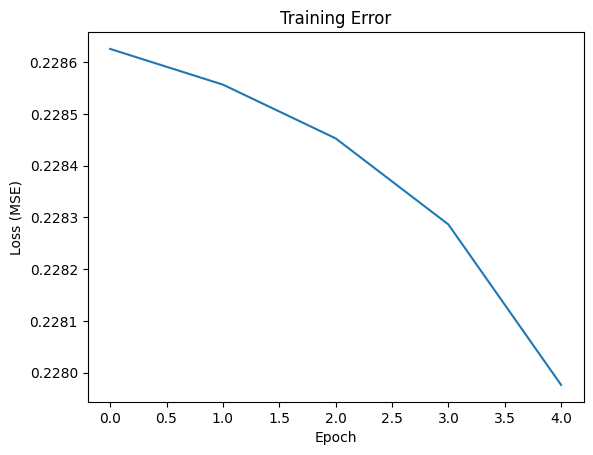

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step
Testing DLMFRecommender (top 10)
Four example recommendations:
    User 1 -> <3568:0.0219 1434:0.0182 262:0.018 451:0.0174 3040:0.0171 724:0.017 34:0.017 1412:0.0168 3406:0.0166 1688:0.0166>
    User 2 -> <978:0.0194 1218:0.0182 2653:0.0182 3925:0.0181 996:0.0181 764:0.0174 518:0.0172 546:0.0168 862:0.0168 2189:0.0166>
    User 3 -> <2441:0.0183 3061:0.018 1102:0.018 2652:0.0179 162:0.0165 3129:0.0163 2044:0.0156 375:0.0155 3678:0.0154 680:0.0151>
    User 4 -> <2890:0.0217 674:0.0201 2115:0.0193 1545:0.019 2360:0.0189 2859:0.0189 1431:0.0185 1291:0.018 3716:0.0178 3355:0.0177>
Precision@10 = 0.025629139072847685
Recall@10 = 0.006493079064176884
--> elapsed time: 0:00:56 <--
-------------------------


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ items (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 50)             │        302,000 │ users[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 50)             │        185,300 │ items[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense (Dense)        │ (None, 50)             │          2,550 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense (Dense)        │ (None, 50)             │          2,550 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1)              │              0 │ user_dense[0][0],      │
│                           │                        │                │ item_dense[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 492,400 (1.88 MB)

 Trainable params: 492,400 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

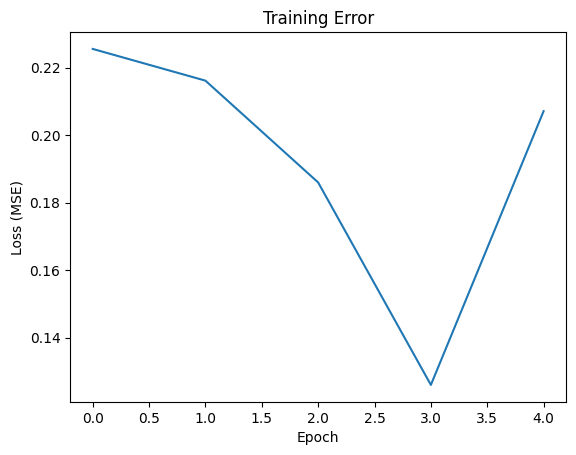

38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step
Testing TwoTowerRecommender (top 10)
Four example recommendations:
    User 1 -> <2396:0.56 2858:0.5309 110:0.5309 1097:0.4972 589:0.4945 1270:0.4893 1210:0.4885 1193:0.4699 1580:0.4688 1617:0.4642>
    User 2 -> <2762:0.8219 2396:0.7865 858:0.7519 1580:0.7416 110:0.7365 260:0.7173 1617:0.7019 1265:0.6869 1:0.686 1240:0.6853>
    User 3 -> <2028:0.4376 2396:0.4054 260:0.4043 589:0.4041 527:0.404 1617:0.3987 1097:0.3953 110:0.3788 2628:0.3776 3578:0.3745>
    User 4 -> <1617:0.3848 589:0.3745 527:0.3692 1270:0.3681 2355:0.3676 608:0.3552 1197:0.354 2396:0.3533 541:0.3455 1580:0.3321>
Precision@10 = 0.15554635761589405
Recall@10 = 0.05443709473682576
--> elapsed time: 0:01:35 <--
-------------------------
Testing Ease (top 10)
Four example recommendations:
    User 1 -> <1148:0.4818 1688:0.4764 2565:0.466 2708:0.4592 588:0.451 2983:0.4496 1032:0.4389 1480:0.4337 2087:0.4201 1666:0.4121>
    User 2 -> <733:0.6353 1580:0.5979 3118:0.5714 1608:0.567

Model: "GRU4Rec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                          │ (32, 50)                    │         563,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 3706)                  │         189,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 752,706 (2.87 MB)

 Trainable params: 752,706 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.0039 - loss: 118086.7188 - top3accuracy: 0.0107
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.0017 - loss: 116667.7891 - top3accuracy: 0.0084
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.0040 - loss: 115800.1328 - top3accuracy: 0.0135
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.0030 - loss: 115268.3203 - top3accuracy: 0.0101
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.0047 - loss: 114605.2266 - top3accuracy: 0.0157
Testing GRU4RecRecommender (top 10)
Four example recommendations:
    User 1 -> <64:0.3197 140:0.3078 99:0.2937 80:0.2742 17:0.2701 526:0.2621 135:0.256 133:0.2486 54:0.243 134:0.2415>
    User 2 -> <64:0.2992 140:0.2892 150:0.285 99:0.276 80:0.2581 17:0.2565 526:0.2494 135:0.2398 133:0.2311 134:0.2294>
    User 3 -> <64:0.3286 140:0.3106 150:0.2979 99:0.2932 80:0.2712 17:0.264 526:0.2604 135:0.2548 133:0.2472 54:0.2469>
    U

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │        474,496 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, 50, 128)        │          6,400 │ embedding[0][0]        │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 50, 128)        │            256 │ positional_embedding[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 50, 128)        │        263,808 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50, 128)        │              0 │ positional_embedding[… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 128)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 50, 128)        │            256 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 512)        │         66,048 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 128)        │         65,664 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 50, 128)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 128)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128)            │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3707)           │        478,203 │ get_item[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,355,131 (5.17 MB)

 Trainable params: 1,355,131 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.0057 - loss: 7.9791
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.0062 - loss: 7.6365
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.0081 - loss: 7.0428
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.0075 - loss: 7.0348
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.0145 - loss: 6.6151
Testing TransformerRecommender (top 10)
Four example recommendations:
    User 1 -> <3526:0.0091 3792:0.0076 2627:0.0075 2715:0.0067 2691:0.0054 2761:0.0053 3255:0.0053 3174:0.0051 2967:0.0051 3447:0.0051>
    User 2 -> <2125:0.0115 3440:0.0078 3704:0.007 2949:0.007 1212:0.0068 3268:0.0057 3767:0.0057 2940:0.0053 207:0.0051 2337:0.0049>
    User 3 -> <3792:0.041 3174:0.0296 3113:0.0282 2761:0.0251 1616:0.0215 3526:0.0165 2627:0.0162 3749:0.0158 2915:0.0148 3607:0.0146>
    User 4 -> <2967:0.0156 3607:0.013 1209:0.011 911:0.0109 2598:0.0105 2761:0.0101 12

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 128)        │        474,496 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, 50, 128)        │          6,400 │ embedding_2[0][0]      │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 50, 128)        │            256 │ positional_embedding_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 50, 128)        │        263,808 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 50, 128)        │              0 │ positional_embedding_… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 50, 128)        │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 50, 128)        │            256 │ dropout_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 50, 512)        │         66,048 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 50, 128)        │         65,664 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 50, 128)        │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 50, 128)        │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 50, 128)        │            256 │ dropout_5[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 50, 128)        │        263,808 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 50, 128)        │              0 │ dropout_5[0][0],       │
│                      

 Total params: 1,751,163 (6.68 MB)

 Trainable params: 1,751,163 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 356ms/step - accuracy: 0.0029 - loss: 8.0238
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 357ms/step - accuracy: 0.0050 - loss: 7.7018
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 358ms/step - accuracy: 0.0096 - loss: 7.0898
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 348ms/step - accuracy: 0.0073 - loss: 7.1472
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 375ms/step - accuracy: 0.0133 - loss: 6.7530
Testing TransformerRecommender (top 10)
Four example recommendations:
    User 1 -> <2627:0.0094 3488:0.0058 3498:0.0057 3268:0.0048 3792:0.0048 3752:0.0044 2761:0.0044 2915:0.0043 3155:0.0043 3417:0.0043>
    User 2 -> <2627:0.0049 3623:0.0048 3079:0.0047 3488:0.0045 3268:0.0042 3592:0.0041 2700:0.004 3237:0.004 2125:0.0039 2018:0.0037>
    User 3 -> <3792:0.0198 2761:0.0194 295:0.0185 3113:0.0176 2627:0.0154 2570:0.0142 2173:0.0134 3360:0.0129 1392:0.0123 2986:0.0123>
    User 4 -> <2761:0.031 2570:0.0269 2627:0.0255 3622:0.0212 3159:0.017 3470:0.015 3

In [10]:
import datetime, time
import warnings
warnings.filterwarnings("ignore")

class CategoricalAccuracy(Metric):
    def __init__(self, test, cutoff=np.inf):
        super().__init__(cutoff)
        dataset = from_ratings_to_sequences(test)
        y_true = np.empty(shape = (len(dataset), 1))
        for i in range(y_true.shape[0]):
            y_true[i, :] = dataset[i][:1]
        self.y_true = tf.constant(y_true, dtype = tf.float32)

    def compute(self, recommendation):
        y_pred = tf.constant(recommendation.ranked_iidx(), dtype = tf.float32)
        acc = (tf.reduce_sum(tf.keras.metrics.top_k_categorical_accuracy(self.y_true, y_pred, k = self.cutoff)) / self.y_true.shape[0]).numpy()
        return acc


# Test data structures and algorithms on a dataset.
def test(ratings_file, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    print(colored(f'Reading the data at ' + time.strftime('%X...'), 'blue'))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix takes {round(10 * ratings.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    timer(start)

    # Produce a rating split and test a set of recommenders.
    train, test = ratings.random_split(0.8)
    train_temp, test_temp = ratings.peruser_sequence_split(ntestitems=1)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    metrics_temp = [Precision(test_temp, cutoff=cutoff, threshold=threshold), Recall(test_temp, cutoff=cutoff, threshold=threshold), CategoricalAccuracy(test_temp, cutoff=1), CategoricalAccuracy(test_temp, cutoff=3), CategoricalAccuracy(test_temp, cutoff=cutoff)]
    run_recommenders(train, metrics, topn)
    run_temp_recommenders(train_temp, metrics_temp, topn)


# Run some recommenders on the some rating data as input - no evaluation.
def run_recommenders(train, metrics, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(DLMFRecommender(train, nepochs=5), metrics, topn)
    start = timer(start)

    print('-------------------------')
    run_recommender(TwoTowerRecommender(train, nepochs=5), metrics, topn)
    start = timer(start)

    print('-------------------------')
    run_recommender(Ease(train, threshold=1), metrics, topn)
    timer(start)

def run_temp_recommenders(train, metrics, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(GRU4RecRecommender(train, nepochs=5, session_length=None, batch_size=32), metrics, topn)
    start = timer(start)

    print('-------------------------')
    run_recommender(TransformerRecommender(train, nlayers=1), metrics, topn)
    start = timer(start)

    print('-------------------------')
    run_recommender(TransformerRecommender(train, nlayers=2), metrics, topn)
    timer(start)

# Run a recommender and evaluate a list of metrics on its output.
def run_recommender(recommender, metrics, topn):
    print(f'Testing {recommender} (top {topn})')
    recommendation = recommender.recommend(topn)
    print('Four example recommendations:\n' + recommendation.display(4))
    for metric in metrics:
        print(metric, '=', metric.compute(recommendation))

from termcolor import colored
def timer(start):
    print(colored(f'--> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()

np.random.seed(0)
print('=========================\nTesting MovieLens \'1 million\' dataset')
test('ratings-1m.dat', topn=10, cutoff=10, sep='::')
print('=========================\nDone.')


=== Student's Additional Tests ===
Reading data at 22:09:20...
Ratings matrix size: 85.4 MB
--> elapsed time: 0:00:08 <--

Creating splits...

[1/5] Testing EASE...
EASE Results: {'Precision@10': 0.3339900662251655, 'Recall@10': 0.15345289497482617}

[2/5] Testing DLMF...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ items (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 50)             │        302,000 │ users[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 50)             │        185,300 │ items[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ user_embedding[0][0],  │
│                           │                        │                │ item_embedding[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 487,300 (1.86 MB)

 Trainable params: 487,300 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

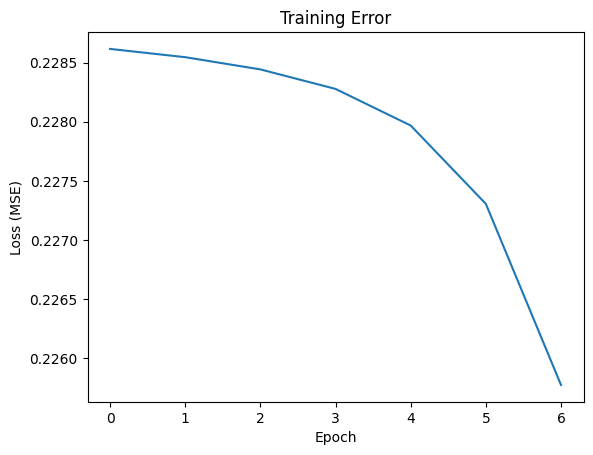

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step
DLMF Results: {'Precision@10': 0.09698675496688741, 'Recall@10': 0.021909574193625592}

[3/5] Testing TwoTower...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ users (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ items (InputLayer)        │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 80)             │        483,200 │ users[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 80)             │        296,480 │ items[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 80)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 80)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense (Dense)        │ (None, 80)             │          6,480 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense (Dense)        │ (None, 80)             │          6,480 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1)              │              0 │ user_dense[0][0],      │
│                           │                        │                │ item_dense[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 792,640 (3.02 MB)

 Trainable params: 792,640 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

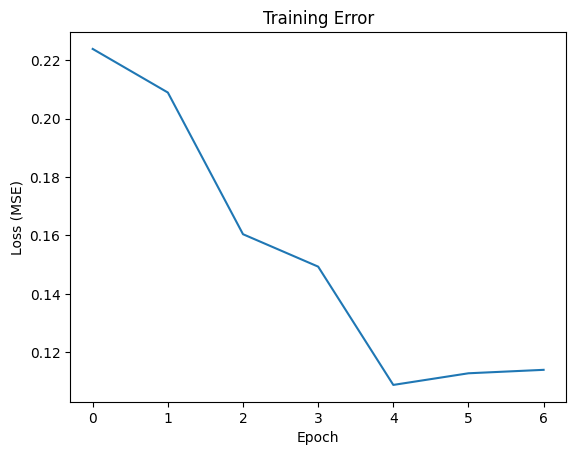

38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step
TwoTower Results: {'Precision@10': 0.10716887417218544, 'Recall@10': 0.04017874158460421}

[4/5] Testing GRU4Rec...


Model: "GRU4Rec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                          │ (8, 1, 50)                  │         563,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_2 (GRU)                          │ (8, 50)                     │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (8, 3706)                   │         189,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 768,006 (2.93 MB)

 Trainable params: 768,006 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

None


0epoch [00:00, ?epoch/s]

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - accuracy: 7.6930e-04 - loss: 29611.6465 - top3accuracy: 0.0018
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 3.9959e-04 - loss: 29553.0684 - top3accuracy: 0.0025
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - accuracy: 0.0035 - loss: 29400.3965 - top3accuracy: 0.0065
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.0042 - loss: 29345.4785 - top3accuracy: 0.0091
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.0085 - loss: 29295.5352 - top3accuracy: 0.0146
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - accuracy: 0.0012 - loss: 29118.3730 - top3accuracy: 0.0054
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.0028 - loss: 29431.3105 - top3accuracy: 0.0054


In [ ]:
# Additional testing?
student_test('ratings-1m.dat', regul=100, nepochs=7, k=80, ngru=2, nlayers=3, nheads=8, topn=10, cutoff=10, threshold=1, sep='::')